# Prévisions sur la location des vélos à Washington, D.C.#

Comme plusieurs villes européennes, beaucoup de villes américaines possèdent des stations de vélos publiques, où vous pouvez louer un vélo pour une durée déterminée. Parmi ces villes, se trouve Washington,D.C.. Le District a collecté les données sur le nombre des vélos loués par heure dans la journée. 

Hadi Fanaee-T, de l'Université de Porto, a compilé ces données dans un fichier de CSV qui contient 17380 lignes, et chaque ligne représentent le nombre des vélos loués pour une heure dans la journée. Vous trouverez le fichier dans [les archives de l'Université de California](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

Exposerons les premières lignes de l'ensemble des données.

In [1]:
import pandas as pd
bikes = pd.read_csv('hour.csv')
bikes.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Voici la description de chaque colonne:

|Colonne|Description|
|-----------|-----------|
|`instant`|L'unique numéro d'identité pour chaque ligne|
|`dteday`|La date de location|
|`season`|La saison de location|
|`yr`|L'année de location|
|`mnth`|Le mois de location|
|`holiday`|Est-ce le jour de vacances ? Oui = 1, Non = 0|
|`weekday`|Le jour en semaine (dénombré de 0 à 7)|
|`workingday`|Est-ce le jour de travail ? Oui = 1, Non = 0|
|`weathersit`|Le climat (variable catégorielle)|
|`temp`|La température, à l'échelle 0-1|
|`atemp`|La température ajustée|
|`hum`|L'humidité, à l'échelle 0-1|
|`windspeed`|La vitesse du vent, à l'échelle 0-1|
|`casual`|Le nombre des locations occasionnelles|
|`registered`|Le nombre des locations abonnées|
|`cnt`|Le total des nombres de locations (occasionnelles + abonnées)|

Dans ce projet, nous essayerons de faire les prévisions sur le nombre total des locations de vélos pour une heure déterminée. Nous ferons les prévisions pour la colonne `cnt` en utilisant toutes les colonnes qui restent, à l'exception de `casual` et `registered`. Pour arriver à le faire, nous allons créer plusieurs modèles de Machine Learning et évaluer leur performance.

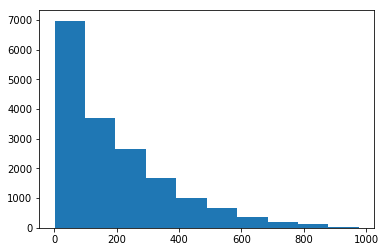

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(bikes['cnt'])
plt.show()

In [3]:
# trouver la corrélation entre 'cnt' et chaque colonne
correlations = bikes.corr()['cnt'].sort_values()
correlations

hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

La température (`temp` et `atemp`) et le moment de la journée (`hr`) sont en plus forte corrélation avec la location des vélos. En effet, on peut imaginer que les locations sont nombreuses en journée et quand la température est agréable; et sont moins nombreuses au soir et quand la température est désagréable...

Par la suite, le numéro d'ID, la saison, les mois, ... sont en corrélation modérée avec la location des vélos.

Enfin, que ce soit le jour du travail ou les vacances, qu'il fait humide ou non, ça n'impacte pas grand chose à la location des vélos.

## Traitement de caractéristiques ##

Il est souvent utile de traiter les caractéristiques avant d'élaborer les algorithmes de Machine Learning (ML). Les caractéristiques peuvent améliorer la précision des modèles grâce à l'introduction de nouveaux éléments.

Par exemple, la colonne `hr` comprend les heures de location, dénombrées de 1 à 24(h). Un modèle va traiter chaque heure d'une manière différente, sans comprendre que certaines heures soient relativement liées. Nous pouvons imposer un nouvel ordre en créant une novelle colonne qui contient des labels pour `morning`, `afternoon`, `evening` et `night`. Cela va grouper les heures ensemble et aide à faire les meilleures décisions.

In [4]:
def assign_label(hour):
    if hour >=0 and hour < 6:
        return 4
    elif hour >= 6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    else:
        return 3
    
bikes['time_label'] = bikes['hr'].apply(lambda x : assign_label(x))
print(bikes['time_label'].unique())
bikes.head()

[4 1 2 3]


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


## Fractionnement de l'ensemble des données  ##

Afin d'éviter le super-apprentissage, nous allons fractionner les données en 2 sous-ensembles : l'un pour le training (80% des données) et l'autre pour le test (20% des données).

On sélectionnera l'Erreur Quadratique Moyenne (EQM) comme mesure de précision. l'EQM fonctionne bien sur les données en continue, ce qui va bien dans notre cas.

In [5]:
train = bikes.sample(frac=.8)
test = bikes.loc[~bikes.index.isin(train.index)]

## Régression linéaire##

Vu qu'il existe plusieurs colonnes qui sont en fortement corrélées avec `cnt`, le modèle de régression linéaire serait un bon candidat pour effectuer les prévisions.

En applicant les colonnes au modèle, on devra ignorer `casual` et `registered` puisque ces dernières s'additionnent à `cnt`. Si l'objectif est de prévenir le nombre total des locations, la connaissance préalable sur `casual` et `registered` donnera aucun sens.

In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

features = bikes.columns.drop(['cnt', 'casual', 'registered', 'dteday'])
target = 'cnt'

lr = LinearRegression()
# fitting le modèle 
lr.fit(train[features], train[target])
# prévisions
predictions = lr.predict(test[features])
# calculer EQM
mse = mean_squared_error(test[target], predictions)
mse

16428.586304353896

Il paraît que l'erreur est assez élevée, du fait qu'il existe certaines locations dites "extrêmement élevées" ou "aberrantes", alors que l'ensemble des locations sont comptées faibles. La présence des valeurs aberrantes a pénalisé l'EQM, ce qui entraîne à une grande erreur.

## Arbres de décisions ##

Nous allons appliquer les arbres de décisions dans le but de comparer l'efficacité entre ceux-ci avec la régression linéaire.

In [7]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr.fit(train[features], train[target])

predictions = dtr.predict(test[features])
mse = mean_squared_error(test[target], predictions)
mse

3337.0981012658226

In [8]:
# modifier le paramètre 'min_samples_leaf' et voir si la modification est efficace
dtr = DecisionTreeRegressor(min_samples_leaf = 3)
dtr.fit(train[features], train[target])

predictions = dtr.predict(test[features])
mse = mean_squared_error(test[target], predictions)
mse

2925.533299210459

In [9]:
# modifier le paramètre 'max_depth' et voir si la modification est efficace
dtr = DecisionTreeRegressor(max_depth = 11)
dtr.fit(train[features], train[target])

predictions = dtr.predict(test[features])
mse = mean_squared_error(test[target], predictions)
mse

3563.689403655979

In [10]:
# combiner les paramètres 'min_samples_leaf' et 'max_depth' et voir si la modification est efficace
dtr = DecisionTreeRegressor(min_samples_leaf=3, max_depth = 11)
dtr.fit(train[features], train[target])

predictions = dtr.predict(test[features])
mse = mean_squared_error(test[target], predictions)
mse

3452.6626272663552

En prenant en compte les facteurs non-linéairs, le modèle d'arbre de décisions rapporte une EQM beaucoup plus faible, surtout quand nous ajoutons les conditions sur les paramètres pour mettre l'arbre plus à l'aise avec l'apprentissage.

## Forêts d'abres décisionnels##

Enfin, nous allons appliquer les forêts d'arbres décisionnels sur l'ensemble des données. La valeur de l'EQM devrait être encore plus faible suite à l'effet des forêts. Autrement dit, la précision sur les prévisions s'améliorerait avec l'application de ce modèle.

In [11]:
from sklearn.ensemble import RandomForestRegressor

# prendre 10 arbres
rf = RandomForestRegressor(10)
rf.fit(train[features], train[target])

predictions = rf.predict(test[features])
mse = mean_squared_error(test[target], predictions)
mse

2189.536470080552

In [12]:
# prendre 100 arbres
rf = RandomForestRegressor(100)
rf.fit(train[features], train[target])

predictions = rf.predict(test[features])
mse = mean_squared_error(test[target], predictions)
mse

1916.3675934407365

In [13]:
#prendre 100 arbres avec modification des paramètres
rf = RandomForestRegressor(10, min_samples_leaf=3)
rf.fit(train[features], train[target])

predictions = rf.predict(test[features])
mse = mean_squared_error(test[target], predictions)
mse

2110.2238150805133

Nous observons que les précisions sur le total des locations ont beaucoup amélioré avec l'application des forêts d'arbres décisionnels. Pour l'instant, nous obtenons la plus faible EQM en établissant 100 arbres tout en mettant les paramètres en défaut. 

# Conclusion #

A travers de ce projet, nous avons appliquer respectivement les modèles de Régression linéaire, d'Arbres de décision et de Forêts d'arbres décisionnels dans le but de minimiser la valeur de l'Erreur Quadratique Moyenne. 

Nous trouvons que les Forêts d'abres décisionnels ont donnée la plus faible EQM, pour une valeur approximative de 1916, avec 100 arbres de décisions rassemblés et sans paramètres rajoutés. Autrement dit, les prévisions sur le total des locations des vélos sont optimisées à l'aide des Forêts d'abres décisionnels. 